# Ping pong result simulator
##### By: Magnus Kvåle Helliesen

Playing ping pong, it appears as if the results 9-6 and 6-9 pop up unreasonably often. Is this to be expected, or are we witnesses to devine intervention? This notebook simulates ping pong matches to see how often these scores "should" in fact pop up by sheer chance.

In [187]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import PowerNorm
from functools import cache

%matplotlib inline

## Functions to simulate a single exhange, a game, and a bunch of games

### Single exchange
First, we make a funciton that returns the simulated result from a single exchange between two players, let's call them *player 0* and *player 1* (to keep it pythoninc).
Each player has a skill $s$, and we let
$$
    s_0=\frac{p_0}{1-p_0},
$$
where $p_0\equiv P(\textrm{player 0 won the exchange})$.
In other words, if $s_0=1$ then player 0 is equally good as player 1 (i.e. has the same probability of winning any given exchange); if $s_0=2$ then player 0 is twice as good as player 1 etc. (It follows that $s_1=1/s_0$, e.g. if player 0 is twice as good as player 1, then player 1 is half as good as player 0.)

Re-writing in terms of propabilities, we have that
$$
    p_0=\frac{s_0}{s_0+1}.
$$
We can verify that
$$
    p_0+p_1=\frac{s_0}{s_0+1}+\frac{1/s_0}{1/s_0+1}=1,
$$
as we require for $p_0$ and $p_1$ to be the probabilities we seek.

The simulation is performed using a uniformily distributet variable $x\sim \mathcal{U}(0,1)$, and player 0 is said to have won the $i\textrm{th}$ exchange if $x_i\leq p_0$. The function returns a pair of boolean values: *person 0 won*, *person 1 won*.

In [188]:
def result_from_single_exchange(s0):
    x = random.uniform(0,1)
    p0 = s0/(s0+1)
    return x <= p0, x > p0

### A game
Next, we make a function that simulates a whole game, that is a sequence of exchanges (using the function above) until the criteriea for having won the game are met (the highest score is at least 11, and the difference in scores is at least 2). The function returns a list of all the scores of the game, that is a list of tuples of *(points player 0, points player 1)*.

In addition to the simple case above, with a skill level $s$ that determines the probability of winning any given exchange, we assume that there is an advantage from serving $k_s$ (which is the same for both players). In particular, we assume that the "effective skill" $s_0^\prime$ with
$$
s_0^\prime=\left\{\begin{array}{ll}
        s_0\cdot k_s & \textrm{if player 0 serves} \\
        s_0/k_s & \textrm{otherwise},
        \end{array} \right.
$$
where $k_s\geq 1$ determines the advantage of serving. ($k_s=1$ denotes no advantage from serving.)

In [189]:
def result_from_game(s0, k_s):
    random_uniform = random.uniform(0,1)
    scores_in_game = [(0, 0)]
    serves_in_game = [(random_uniform <= 0.5, random_uniform > 0.5)]
    serves_in_game.append((serves_in_game[0][1], serves_in_game[0][0]))
    serves = 2
    while (max(scores_in_game[-1][0], scores_in_game[-1][1]) < 11) or (abs(scores_in_game[-1][0]-scores_in_game[-1][1]) < 2):
        if min(scores_in_game[-1][0], scores_in_game[-1][1]) >= 10:
            serves = 1
        s0_prime = s0/k_s if not serves_in_game[-1][0] else s0*k_s
        player0_won, player1_won = result_from_single_exchange(s0_prime)
        scores_in_game.append((scores_in_game[-1][0]+player0_won, scores_in_game[-1][1]+player1_won))
        serves_in_game.append((not serves_in_game[-1][0] if serves_in_game[-1][0] == serves_in_game[-serves][0] else serves_in_game[-1][0],
                               not serves_in_game[-1][1] if serves_in_game[-1][1] == serves_in_game[-serves][1] else serves_in_game[-1][1]
                               ))
    return scores_in_game

Lets look at an example game between two equally good players, i.e. $s_0 = 1$, where $k_s=2$.

In [190]:
# An example game between equally good players
example_game = result_from_game(1, 2)

In [191]:
# All scores of the game
print(*['-'.join(map(str, x)) for x in example_game], sep='\n')

0-0
0-1
0-2
1-2
1-3
1-4
2-4
2-5
2-6
3-6
4-6
4-7
5-7
5-8
5-9
6-9
7-9
8-9
9-9
10-9
11-9


In [192]:
# The game ended with the score
print(*example_game[-1], sep='-')

11-9


### A bunch of games
We generate a function that simulates $n$ games and stores all the results to a list. (We will be able to distinguish between games later because every game starts with 0-0.)

In [193]:
def game_simulator(s0, advantage_of_serve, n, seed):
    random.seed(seed)
    simulation_of_games = []
    for i in range(n):
        simulation_of_games.extend(result_from_game(s0, advantage_of_serve))
    return simulation_of_games

## Results from simulation

#### Results from simulation of games between equal players
We now simulate 100,000 games between equaly skilled players and store it to a list. We then put it in a DataFrame, manipulate it, and plot it as a heatmap. We see that scores along the diagonal (that is, farily even matches) are the most frequent. Nevertheless, every so often a player wins 11 to nothing, and sometimes the game goes on until 25 points and more. Note that the heatmap uses a power-transformation, that is count is raised to the 1/4th power to make the plot a bit more busy. The reason is that otherwise 0-0 dominats the plot as it occurs every game.

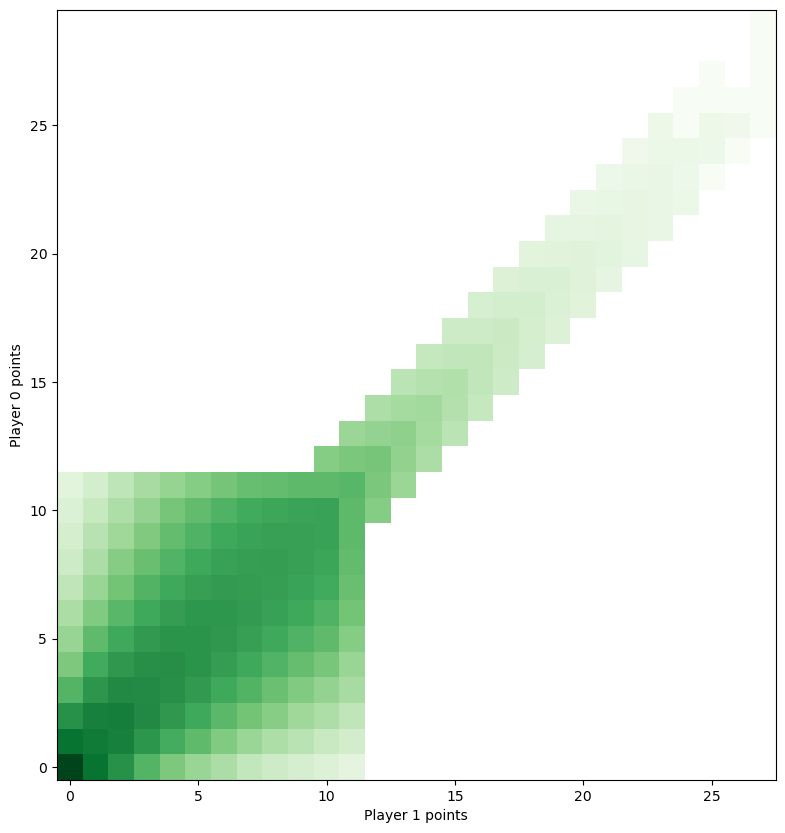

In [194]:
simulation_of_games = game_simulator(1, 2, 100000, 1234)

df = pd.DataFrame(simulation_of_games, columns=['player0_points', 'player1_points'])

df_to_plot = (
    pd.DataFrame(simulation_of_games, columns=['player0_points', 'player1_points'])
    .assign(**{'': 1})
    .groupby(['player0_points', 'player1_points'])
    .count()
    .reset_index()
    .pivot_table(index=['player0_points'], columns=['player1_points'])
)

plt.figure(figsize=(10, 10))
plt.imshow(df_to_plot, origin='lower', cmap ="Greens", norm=PowerNorm(0.25))
plt.ylabel('Player 0 points')
plt.xlabel('Player 1 points')
plt.show()

We also calculate the simulated probability of having the score result 9-6 or 6-9 in any given match. We see that it's about 30 %.

In [195]:
df = df.assign(**{'new_match': lambda df: [1 if (p1, p2) == (0, 0) else 0 for p1, p2 in zip(df['player0_points'], df['player1_points'])]})
df = df.assign(**{'match_id': lambda df: df['new_match'].cumsum()})
df = df.assign(**{'96/69': lambda df: [1 if (p1, p2) in ((9, 6), (6, 9)) else 0 for p1, p2 in zip(df['player0_points'], df['player1_points'])]})
df.groupby(df['match_id'])['96/69'].sum().mean()

0.31375

#### Results from simulations for differen values of $s_0$
We now make a function that makes neat subplots for different relative skill levels, $s_0$.

In [196]:
@cache
def result_creator(advantage_of_serve, n, seed):
    fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(15, 17.5))
    #fig.tight_layout(pad=1.0)
    fig.supylabel('Player 0 points')
    fig.supxlabel('Player 1 points')
    fig.suptitle('Heatmap of scores for different skill levels of player 0, $s_0$')
    fig.tight_layout(rect=[0, 0, 1, 1])
    prob = []
    p0 = []
    i, j = 0, 0
    for s0 in [1.2**i for i in range(-12, 13)]:
        simulation_of_games = game_simulator(s0, advantage_of_serve, n, 1234)

        df = pd.DataFrame(simulation_of_games, columns=['player0_points', 'player1_points'])

        df_to_plot = (
            pd.DataFrame(simulation_of_games, columns=['player0_points', 'player1_points'])
            .assign(**{'': 1})
            .groupby(['player0_points', 'player1_points'])
            .count()
            .reset_index()
            .pivot_table(index=['player0_points'], columns=['player1_points'])
        )

        ax[j ,i].imshow(df_to_plot, origin='lower',cmap ="Greens", norm=PowerNorm(0.25))
        ax[j ,i].title.set_text(''.join(['$s_0$=','{0:.2f}'.format(s0), ' ($p_0=$' , '{0:.2f}'.format(s0/(s0+1)), ')']))
        ax[j ,i].set_xlim((0, 20))
        ax[j ,i].set_ylim((0, 20))
        ax[j ,i].yaxis.set_major_locator(MaxNLocator(integer=True))
        ax[j ,i].xaxis.set_major_locator(MaxNLocator(integer=True))
        
        df = df.assign(**{'new_match': lambda df: [1 if (p1, p2) == (0, 0) else 0 for p1, p2 in zip(df['player0_points'], df['player1_points'])]})
        df = df.assign(**{'match_id': lambda df: df['new_match'].cumsum()})
        df = df.assign(**{'96/69': lambda df: [1 if (p1, p2) in ((9, 6), (6, 9)) else 0 for p1, p2 in zip(df['player0_points'], df['player1_points'])]})
        prob.append(df.groupby(df['match_id'])['96/69'].sum().mean())
        p0.append(s0/(s0+1))
        
        if i == 4:
            i = 0
            j += 1
        else:
            i += 1

    plt.figure(figsize=(10, 10))
    plt.plot(p0, prob, color='Blue', linewidth=3)
    plt.title('Simulated density of score 9-6 and 6-9 for different values of $p_0$')
    plt.show()

We show a grid of densities for different values of $s_0$ along with a plot of probabilities for the scores 9-6 *or* 6-9 popping up in a game for different values of $s_0$.

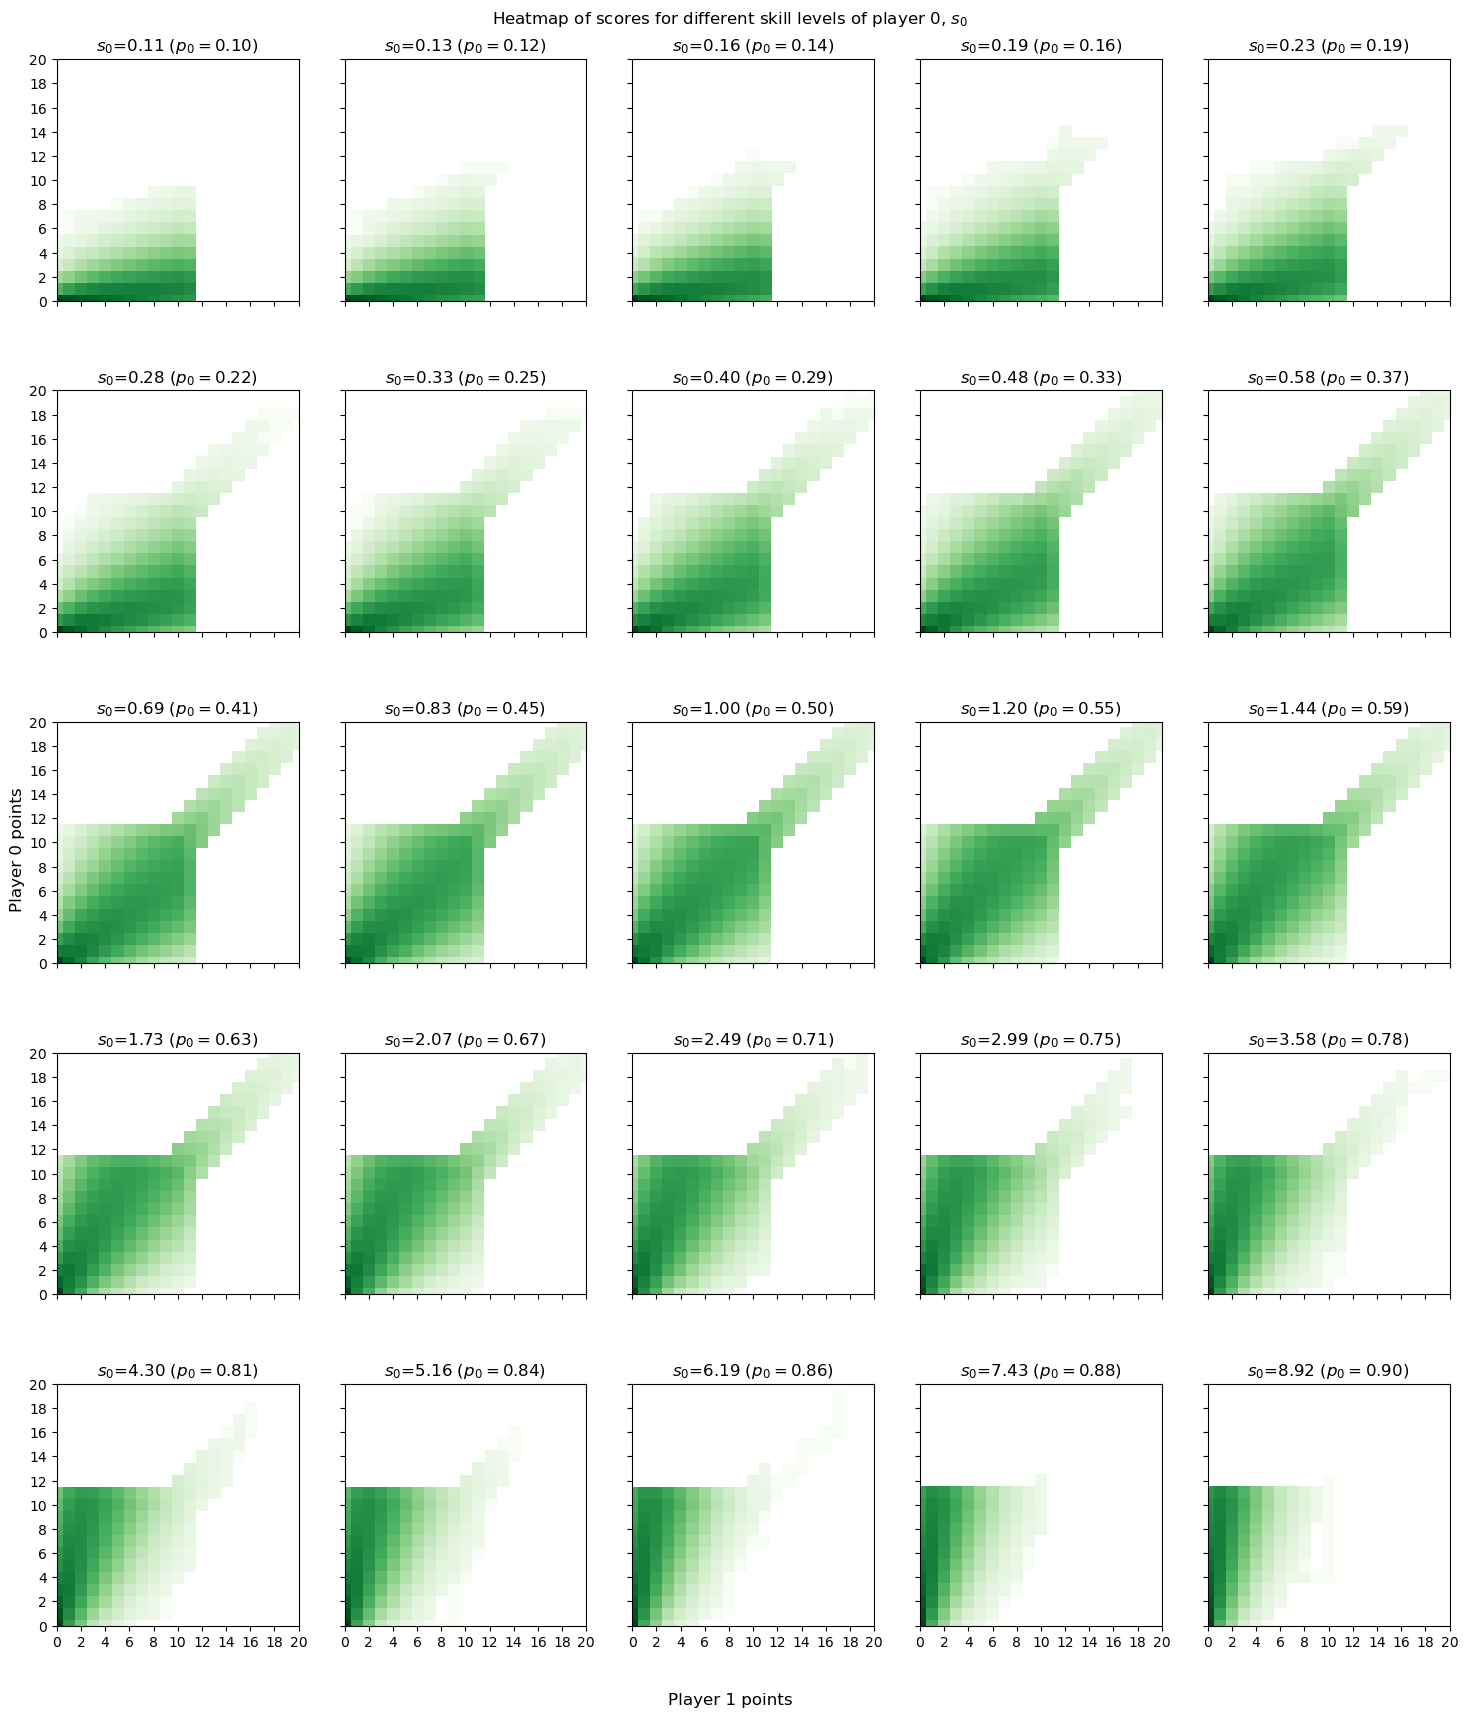

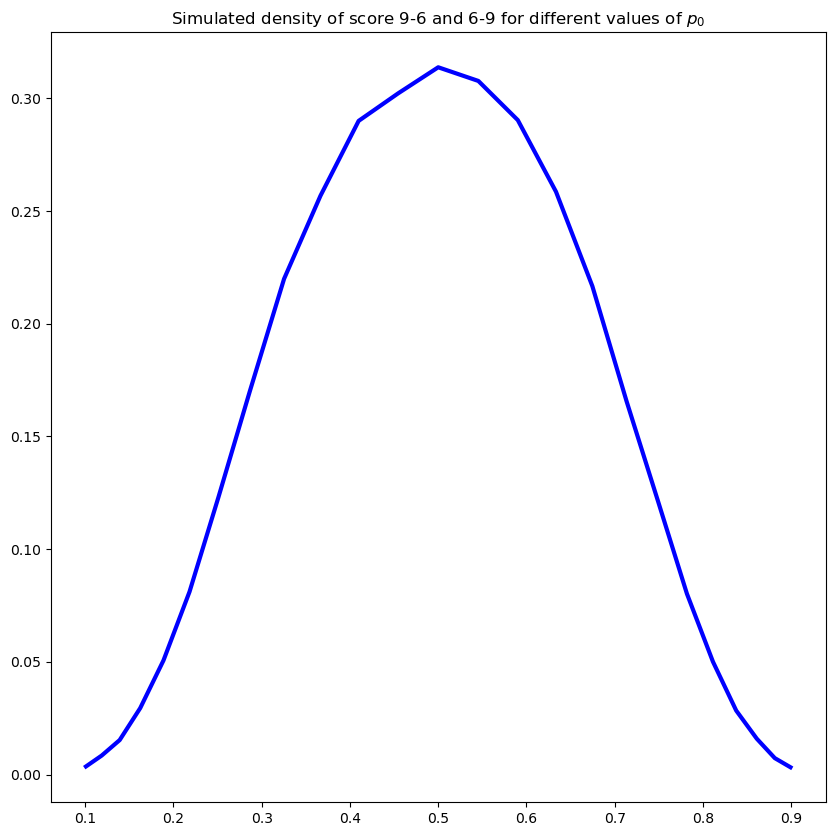

In [197]:
result_creator(2, 100000, 1234)